# Classification of the breed of chickens using Data Augmentation and Transfer Learning
In this notebook a CNN is created to distinguish between nine different chickens (of different breeds).
First a baseline model is built and then enhanced with Data Augmentation and Transfer Learning.

## Imports
All dependencies needed for the model are loaded here.

In [57]:
%matplotlib inline
import os
import shutil
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Concatenate, AvgPool2D, Input, Softmax
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from tensorflow.keras import Model
from tensorflow.keras import layers

## Load the training and validation images
The images are in a folder `Chickens` where each of the nine chickens has its own subdirectory.
For further use the images are copied to `/tmp` where each model will load them from.

In [58]:
#from google.colab import drive
#drive.mount('/content/drive')

In [59]:
# Google Colab
# DATASET_PATH = '/tmp/chickens'
# BASE_PATH = '/content/drive/MyDrive/Chickens'

# Hannes
BASE_PATH = '/Users/hannes/Google Drive/My Drive/Chickens'
DATASET_PATH = '/tmp/Chickens'

# Paul
# BASE_PATH = '/Users/pkeller/Pictures/chickens'
# DATASET_PATH = '/Users/pkeller/Pictures/AIchickens'

blacklisted_files = ['.DS_Store', 'Icon\r']
# Allows to use only a subset of the available classes for training
# breeds = ['Amaretto', 'Aria', 'Chick Pea', 'Espresso', 'Lucifer', 'Oreo', 'Popcorn', 'Pumpkin', 'Whiskey']
breeds = ['Aria', 'Lucifer', 'Popcorn']

# Cleanup existing files to always start with a clean slate
if os.path.exists(DATASET_PATH):
    shutil.rmtree(DATASET_PATH)
    print('Removed existing files')

os.mkdir(DATASET_PATH)

num_copied_files = 0

for breed in breeds:
    breed_source_path = os.path.join(BASE_PATH, breed)
    breed_target_path = os.path.join(DATASET_PATH, breed)

    if os.path.isdir(breed_source_path):
        os.mkdir(breed_target_path)

        for image in os.listdir(breed_source_path):
            sourcePath = os.path.join(breed_source_path, image)
            targetPath = os.path.join(breed_target_path, image)
            shutil.copy(sourcePath, targetPath)
            num_copied_files += 1

# remove .DS_store and other wrong files
for breed in breeds:
    if breed in blacklisted_files:
        path_to_file = os.path.join(DATASET_PATH, breed)
        os.remove(path_to_file)
        print(path_to_file + ' removed')
        num_copied_files -= 1
        continue

    breed_directory = os.path.join(DATASET_PATH, breed)

    if os.path.isdir(breed_directory):
        for filename in os.listdir(breed_directory):
            if filename in blacklisted_files:
                path_to_file = os.path.join(breed_directory, filename)
                os.remove(path_to_file)
                print(path_to_file + ' removed')
                num_copied_files -= 1

print(f"Copied {num_copied_files} files")
print(f"We have {len(breeds)} chickens")

Removed existing files
Copied 450 files
We have 3 chickens


## Explore dataset
Next we explore the dataset a bit by showing a random collection of each chicken.

There are 150 images of Aria.


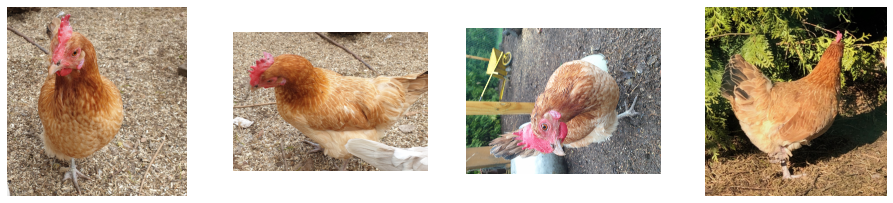

There are 150 images of Lucifer.


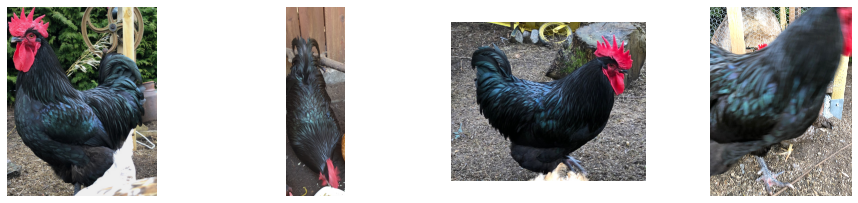

There are 150 images of Popcorn.


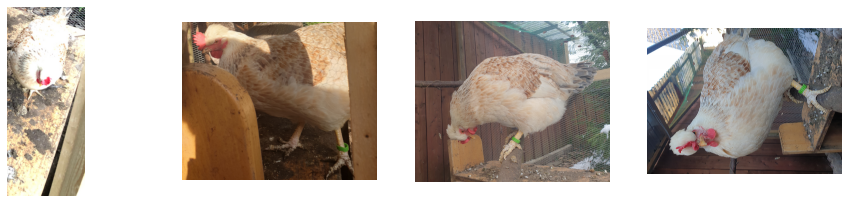

In [60]:
for breed in breeds:
  breed_directory = os.path.join(DATASET_PATH, breed)
  breed_dir_list = os.listdir(breed_directory)

  print(f"There are {len(breed_dir_list)} images of {breed}.")
  
  # show images of dataset
  rows = 4
  cols = 4
  pic_index = 0
  fig = plt.gcf()
  fig.set_size_inches(cols * 4, rows * 4)
  pic_index+=4
  next_pic = [os.path.join(breed_directory, file_name)
              for file_name in breed_dir_list[pic_index - 4:pic_index]
              ]
  for i, img_path in enumerate(next_pic):
    #subplot
    sp = plt.subplot(rows, cols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

## Global parameters
Here some global parameters are set to be consistent in each model that is built.

In [61]:
BATCH_SIZE = 32
EPOCHS = 100
SEED = 42
# IMG_SIZE = int(244 / 10)
IMG_SIZE = 299
SPLIT = 0.3 # 70% training images and 30% validation images

#### Tensorboard settings

In [62]:
import time
# log directory "logs" 
root_logdir = os.path.join(os.curdir, "logs")

# function that prepends the time of a run
def get_run_logdir(name: str = ""):
  run_id = time.strftime("%m_%d-%H_%M")
  run_name = run_id + name
  return os.path.join(root_logdir, run_name)

## First Model
As a start we build a very simple model without any Data Augmentation or Transfer Learning.

### Get the training and validation data

In [63]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='training',
                                             seed=SEED)
validation_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation',
                                             seed=SEED)

Found 315 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


### Create the model

In [64]:
def inception_stem(input_tensor):
    """
    Creates the stem for the Inception V4 model.

    :param input_tensor: the input tensor
    :return: the concatenated block
    """
    layer_1_conv_1 = Conv2D(32, (3, 3), strides=(2, 2), padding='valid', activation='relu')(input_tensor)
    layer_1_conv_2 = Conv2D(32, (3, 3), padding='valid', activation='relu')(layer_1_conv_1)
    layer_1_conv_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(layer_1_conv_2)

    layer_1_max_pool = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(layer_1_conv_3)
    layer_1_conv_4 = Conv2D(96, (3, 3), strides=(2, 2), padding='valid', activation='relu')(layer_1_conv_3)

    layer_1_concat = Concatenate(axis=3)([layer_1_max_pool, layer_1_conv_4])

    layer_2_conv_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(layer_1_concat)
    layer_2_conv_2 = Conv2D(96, (3, 3), padding='valid', activation='relu')(layer_2_conv_1)

    layer_2_conv_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(layer_1_concat)
    layer_2_conv_4 = Conv2D(64, (7, 1), padding='same', activation='relu')(layer_2_conv_3)
    layer_2_conv_5 = Conv2D(64, (1, 7), padding='same', activation='relu')(layer_2_conv_4)
    layer_2_conv_6 = Conv2D(96, (3, 3), padding='valid', activation='relu')(layer_2_conv_5)

    layer_2_concat = Concatenate(axis=3)([layer_2_conv_2, layer_2_conv_6])

    layer_3_conv = Conv2D(192, (3, 3), strides=(2, 2), padding='valid', activation='relu')(layer_2_concat)
    layer_3_max_pool = MaxPool2D((2, 2), strides=(2, 2), padding='valid')(layer_2_concat)

    return Concatenate(axis=3)([layer_3_conv, layer_3_max_pool])

def inception_block_a(input_layer):
    """
    Creates a block A type Inception V4 block.

    :param input_layer: the layer to base this block on
    :return: the concatenated block
    """
    block_layers = []

    layer_1_pool = AvgPool2D((1, 1), padding='same')(input_layer)
    layer_1_conv = Conv2D(96, (1, 1), padding='same', activation='relu')(layer_1_pool)
    block_layers.append(layer_1_conv)

    layer_2_conv = Conv2D(96, (1, 1), padding='same', activation='relu')(input_layer)
    block_layers.append(layer_2_conv)

    layer_3_conv_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_layer)
    layer_3_conv_2 = Conv2D(96, (3, 3), padding='same', activation='relu')(layer_3_conv_1)
    block_layers.append(layer_3_conv_2)

    layer_4_conv_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_layer)
    layer_4_conv_2 = Conv2D(96, (3, 3), padding='same', activation='relu')(layer_4_conv_1)
    layer_4_conv_3 = Conv2D(96, (3, 3), padding='same', activation='relu')(layer_4_conv_2)
    block_layers.append(layer_4_conv_3)

    return Concatenate(axis=3)(block_layers)

def inception_block_b(input_layer):
    """
    Creates a block B type Inception V4 block.

    :param input_layer: the layer to base this block on
    :return: the concatenated block
    """
    block_layers = []

    layer_1_pool = AvgPool2D((1, 1), padding='same')(input_layer)
    layer_1_conv = Conv2D(128, (1, 1), padding='same', activation='relu')(layer_1_pool)
    block_layers.append(layer_1_conv)

    layer_2_conv = Conv2D(384, (1, 1), padding='same', activation='relu')(input_layer)
    block_layers.append(layer_2_conv)

    layer_3_conv_1 = Conv2D(192, (1, 1), padding='same', activation='relu')(input_layer)
    layer_3_conv_2 = Conv2D(224, (1, 7), padding='same', activation='relu')(layer_3_conv_1)
    layer_3_conv_3 = Conv2D(256, (1, 7), padding='same', activation='relu')(layer_3_conv_2)
    block_layers.append(layer_3_conv_3)

    layer_4_conv_1 = Conv2D(192, (1, 1), padding='same', activation='relu')(input_layer)
    layer_4_conv_2 = Conv2D(192, (1, 7), padding='same', activation='relu')(layer_4_conv_1)
    layer_4_conv_3 = Conv2D(224, (7, 1), padding='same', activation='relu')(layer_4_conv_2)
    layer_4_conv_4 = Conv2D(224, (1, 7), padding='same', activation='relu')(layer_4_conv_3)
    layer_4_conv_5 = Conv2D(256, (7, 1), padding='same', activation='relu')(layer_4_conv_4)
    block_layers.append(layer_4_conv_5)

    return Concatenate(axis=3)(block_layers)

def inception_block_c(input_layer):
    """
    Creates a block C type Inception V4 block.

    :param input_layer: the layer to base this block on
    :return: the concatenated block
    """
    block_layers = []

    layer_1_pool = AvgPool2D((1, 1), padding='same')(input_layer)
    layer_1_conv = Conv2D(256, (1, 1), padding='same', activation='relu')(layer_1_pool)
    block_layers.append(layer_1_conv)

    layer_2_conv = Conv2D(256, (1, 1), padding='same', activation='relu')(input_layer)
    block_layers.append(layer_2_conv)

    layer_3_conv = Conv2D(384, (1, 1), padding='same', activation='relu')(input_layer)
    layer_3_concat_conv_1 = Conv2D(256, (1, 3), padding='same', activation='relu')(layer_3_conv)
    layer_3_concat_conv_2 = Conv2D(256, (3, 1), padding='same', activation='relu')(layer_3_conv)
    layer_3_concat = Concatenate(axis=3)([layer_3_concat_conv_1, layer_3_concat_conv_2])
    block_layers.append(layer_3_concat)

    layer_4_conv_1 = Conv2D(384, (1, 1), padding='same', activation='relu')(input_layer)
    layer_4_conv_2 = Conv2D(448, (1, 3), padding='same', activation='relu')(layer_4_conv_1)
    layer_4_conv_3 = Conv2D(512, (3, 1), padding='same', activation='relu')(layer_4_conv_2)
    layer_4_concat_conv_1 = Conv2D(256, (1, 3), padding='same', activation='relu')(layer_4_conv_3)
    layer_4_concat_conv_2 = Conv2D(256, (3, 1), padding='same', activation='relu')(layer_4_conv_3)
    layer_4_concat = Concatenate(axis=3)([layer_4_concat_conv_1, layer_4_concat_conv_2])
    block_layers.append(layer_4_concat)

    return Concatenate(axis=3)(block_layers)

def inception_reduction_a(input_layer):
    """
    Creates a reduction A type Inception V4 block.

    :param input_layer: the layer to base this block on
    :return: the concatenated block
    """
    block_layers = []

    layer_1_conv = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(input_layer)
    block_layers.append(layer_1_conv)

    layer_2_conv = Conv2D(384, (3, 3), strides=(2, 2), padding='valid', activation='relu')(input_layer)
    block_layers.append(layer_2_conv)

    layer_3_conv_1 = Conv2D(192, (1, 1), padding='same', activation='relu')(input_layer)
    layer_3_conv_2 = Conv2D(224, (3, 3), padding='same', activation='relu')(layer_3_conv_1)
    layer_3_conv_3 = Conv2D(256, (3, 3), strides=(2, 2), padding='valid', activation='relu')(layer_3_conv_2)
    block_layers.append(layer_3_conv_3)

    return Concatenate(axis=3)(block_layers)

def inception_reduction_b(input_layer):
    """
    Creates a reduction B type Inception V4 block.

    :param input_layer: the layer to base this block on
    :return: the concatenated block
    """
    block_layers = []

    layer_1_conv = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(input_layer)
    block_layers.append(layer_1_conv)

    layer_2_conv_1 = Conv2D(192, (1, 1), padding='same', activation='relu')(input_layer)
    layer_2_conv_2 = Conv2D(192, (3, 3), strides=(2, 2), padding='valid', activation='relu')(layer_2_conv_1)
    block_layers.append(layer_2_conv_2)

    layer_3_conv_1 = Conv2D(256, (1, 1), padding='same', activation='relu')(input_layer)
    layer_3_conv_2 = Conv2D(256, (1, 7), padding='same', activation='relu')(layer_3_conv_1)
    layer_3_conv_3 = Conv2D(320, (7, 1), padding='same', activation='relu')(layer_3_conv_2)
    layer_3_conv_4 = Conv2D(320, (3, 3), strides=(2, 2), padding='valid', activation='relu')(layer_3_conv_3)
    block_layers.append(layer_3_conv_4)

    return Concatenate(axis=3)(block_layers)

In [65]:
def create_model():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    stem = inception_stem(input_tensor)

    a_block_1 = inception_block_a(stem)
    a_block_2 = inception_block_a(a_block_1)
    a_block_3 = inception_block_a(a_block_2)
    a_block_4 = inception_block_a(a_block_3)

    a_reduction = inception_reduction_a(a_block_4)

    b_block_1 = inception_block_b(a_reduction)
    b_block_2 = inception_block_b(b_block_1)
    b_block_3 = inception_block_b(b_block_2)
    b_block_4 = inception_block_b(b_block_3)
    b_block_5 = inception_block_b(b_block_4)
    b_block_6 = inception_block_b(b_block_5)
    b_block_7 = inception_block_b(b_block_6)

    b_reduction = inception_reduction_b(b_block_7)

    c_block_1 = inception_block_c(b_reduction)
    c_block_2 = inception_block_c(c_block_1)
    c_block_3 = inception_block_c(c_block_2)

    avg_pool_layer = AvgPool2D()(c_block_3)

    dropout_layer = Dropout(0.2)(avg_pool_layer)

    softmax_layer = Softmax(axis=3)(dropout_layer)

    inception_v4 = Model(input_tensor, softmax_layer)

    model = Sequential()
    model.add(inception_v4)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(breeds), activation='softmax'))

    model.compile(optimizer=RMSprop(),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

model = create_model()

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_9 (Functional)        (None, 4, 4, 1536)        41111232  
                                                                 
 flatten_9 (Flatten)         (None, 24576)             0         
                                                                 
 dense_20 (Dense)            (None, 1024)              25166848  
                                                                 
 dropout_21 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 66,281,155
Trainable params: 66,281,155
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Tensorboard
tensorboard = keras.callbacks.TensorBoard(get_run_logdir("#1.Model"), 
                                             histogram_freq=1,)
          
history = model.fit(train_generator,
                    epochs=int(EPOCHS),
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[tensorboard])

Epoch 1/100


2022-06-28 10:25:30.358917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 1.1108 - accuracy: 0.2952

2022-06-28 10:27:44.650471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 171s 10s/step - loss: 1.1108 - accuracy: 0.2952 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 2/100
10/10 [==============================] - 50s 5s/step - loss: 1.1042 - accuracy: 0.3143 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 3/100
10/10 [==============================] - 54s 5s/step - loss: 1.1009 - accuracy: 0.3016 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 4/100
10/10 [==============================] - 45s 5s/step - loss: 1.1023 - accuracy: 0.3238 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/100
10/10 [==============================] - 45s 5s/step - loss: 1.0998 - accuracy: 0.3143 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 6/100
10/10 [==============================] - 45s 4s/step - loss: 1.1010 - accuracy: 0.3111 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/100
10/10 [==============================] - 46s 5s/step - loss: 1.1010 - accuracy: 0.3048 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 8/100
10/10 [====

KeyboardInterrupt: 

In [ ]:
def plot_training_validation_accuracy_loss(history_to_plot):
    acc = history_to_plot.history['accuracy']
    val_acc = history_to_plot.history['val_accuracy']
    loss = history_to_plot.history['loss']
    val_loss = history_to_plot.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
plot_training_validation_accuracy_loss(history)

As we can see the accuracy is not even near a good value.
In the next parts we will try some measures to gain a better accuracy.

## 1. Measure: Data Augmentation

In [50]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT,
                                            rotation_range=20,
                                            width_shift_range=0.1,                               
                                            height_shift_range=0.1,
                                            shear_range=0.1,                          
                                            zoom_range=0.1,                          
                                            horizontal_flip=True,
                                            fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            subset='training',
                                            seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

validation_generator = test_datagen.flow_from_directory(DATASET_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation',
                                             seed=SEED)

Found 735 images belonging to 9 classes.
Found 315 images belonging to 9 classes.


In [51]:
model2 = create_model()

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 4, 4, 1536)        41111232  
                                                                 
 flatten_6 (Flatten)         (None, 24576)             0         
                                                                 
 dense_14 (Dense)            (None, 1024)              25166848  
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 9)                 9225      
                                                                 
Total params: 66,287,305
Trainable params: 66,287,305
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Tensorboard
tensorboard = keras.callbacks.TensorBoard(get_run_logdir("#2.Model"), 
                                             histogram_freq=1,)
         
history2 = model2.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1,
            callbacks=[tensorboard])

Epoch 1/100


2022-06-28 09:42:11.296824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - ETA: 0s - loss: 2.1926 - accuracy: 0.1374

2022-06-28 09:44:10.512630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 155s 5s/step - loss: 2.1926 - accuracy: 0.1374 - val_loss: 2.1877 - val_accuracy: 0.1429
Epoch 2/100
23/23 [==============================] - 79s 3s/step - loss: 2.1869 - accuracy: 0.1429 - val_loss: 2.1839 - val_accuracy: 0.1429
Epoch 3/100
23/23 [==============================] - 79s 3s/step - loss: 2.1827 - accuracy: 0.1429 - val_loss: 2.1813 - val_accuracy: 0.1429
Epoch 4/100
23/23 [==============================] - 78s 3s/step - loss: 2.1806 - accuracy: 0.1429 - val_loss: 2.1799 - val_accuracy: 0.1429
Epoch 5/100
23/23 [==============================] - 78s 3s/step - loss: 2.1801 - accuracy: 0.1429 - val_loss: 2.1792 - val_accuracy: 0.1429
Epoch 6/100
23/23 [==============================] - 78s 3s/step - loss: 2.1794 - accuracy: 0.1429 - val_loss: 2.1787 - val_accuracy: 0.1429
Epoch 7/100
23/23 [==============================] - 78s 3s/step - loss: 2.1800 - accuracy: 0.1429 - val_loss: 2.1784 - val_accuracy: 0.1429
Epoch 8/100
23/23 [=====

KeyboardInterrupt: 

In [ ]:
plot_training_validation_accuracy_loss(history2)

**2. Measure: VGG19Model**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(DATASET_PATH,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(244,244),
                                                    subset='training',
                                                    seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT)

validation_generator = test_datagen.flow_from_directory(DATASET_PATH,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        target_size=(244,244),
                                                        subset='validation',
                                                        seed=SEED)

In [ ]:
# Import the VGG-19 model  
from keras.applications.vgg19 import VGG19

vgg19_model = VGG19(input_shape = (244, 244, 3),
include_top = False, 
weights = 'imagenet')

In [ ]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [ ]:
vgg19_model.summary()


#### Hyperparamater

In [ ]:
from tensorboard.plugins.hparams import api as hp
metric_accuracy = 'accuracy'
num_of_units = hp.HParam('num_units', hp.Discrete([32, 64, 256, 1024]))
#num_of_units_two = hp.HParam('num_units_two', hp.Discrete([32, 64, 256, 1024]))
#num_of_units_three = hp.HParam('num_units_three', hp.Discrete([32, 64, 256, 1024]))
dropout = hp.HParam('dropout', hp.RealInterval(0.2, 0.4))
#opti = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))

In [ ]:
from keras import layers
from keras import Model

def create_and_train_model(hparams: dict, vgg19_model):
    last_layer = layers.Flatten()(vgg19_model.get_layer('block5_conv4').output)

    last_layer = layers.Dense(hparams[num_of_units], activation='relu')(last_layer)
    last_layer = layers.Dropout(hparams[dropout])(last_layer) 

    last_layer = layers.Dense(hparams[num_of_units], activation='relu')(last_layer)
    last_layer = layers.Dropout(hparams[dropout])(last_layer) 

    last_layer = layers.Dense(hparams[num_of_units], activation='relu')(last_layer)
    last_layer = layers.Dropout(hparams[dropout])(last_layer)     
     
    last_layer = layers.Dense(len(breeds), activation='softmax')(last_layer)
    
    model = Model(inputs=vgg19_model.input, outputs=last_layer)

    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    model.fit(train_generator, validation_data=(validation_generator), epochs=50)
    
    loss, accuracy = model.evaluate(validation_generator)
    
    return accuracy

In [ ]:
# Set up for Tensorboardhyperparamtest
if os.path.exists('logs/param_test'):
  shutil.rmtree('logs/param_test')

with tf.summary.create_file_writer('logs/param_test').as_default():
    hp.hparams_config(
        #hparams=[num_of_units,num_of_units_two,num_of_units_three, dropout],
        hparams=[num_of_units, dropout],
        metrics=[hp.Metric(metric_accuracy, display_name='Accuracy')],)

def experiment(experiment_dir, hparams):
    with tf.summary.create_file_writer(experiment_dir).as_default():
        hp.hparams(hparams)
        accuracy = create_and_train_model(hparams, vgg19_model) # experiment run
        tf.summary.scalar(metric_accuracy, accuracy, step=1)

In [ ]:
test_number = 0 # test counter
for num_units in num_of_units.domain.values: # try all four different values
    #for num_units_two in num_of_units_two.domain.values: # try all four different values
     #   for num_units_three in num_of_units_three.domain.values: # try all four different values
    for dropout_rate in (dropout.domain.min_value, dropout.domain.max_value): # try min and max value of dropout
        #for optimizer in opti.domain.values: # try all two different optimizers
        hparams = {
                num_of_units: num_units,
                  #  num_of_units_two: num_units_two,
                   # num_of_units_three: num_units_three,
                dropout: dropout_rate,
              #  opti: optimizer,
        }

        test_name = f'Test {test_number}'
        print(f'Starting Test: {test_name}')
        print({h.name: hparams[h] for h in hparams})
        experiment('logs/param_test/' + test_name, hparams)
        test_number += 1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/param_test
%reload_ext tensorboard

#### Result of hyperparamtest

number of units: 1024
dropout: 0.2
optimizer: rmsprop

#### Create final model

In [ ]:
def create_final_model(vgg19_model):
    last_layer = layers.Flatten()(vgg19_model.get_layer('block5_conv4').output)
    last_layer = layers.Dense(1024, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)
    last_layer = layers.Dense(1024, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)
    last_layer = layers.Dense(1024, activation='relu')(last_layer)
    last_layer = layers.Dropout(0.2)(last_layer)
    last_layer = layers.Dense(len(breeds), activation='softmax')(last_layer)

    model = Model(inputs=vgg19_model.input, outputs=last_layer)

    model.compile(optimizer = 'rmsprop', 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [ ]:
model = create_final_model(vgg19_model)

In [ ]:
# Tensorboard
tensorboard = keras.callbacks.TensorBoard(get_run_logdir("#3.Model"), 
                                             histogram_freq=1,)
history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1, 
            callbacks=[tensorboard])
            

In [ ]:
plot_training_validation_accuracy_loss(history)

### Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./logs
%reload_ext tensorboard 